# Bidirectional PC on MNIST

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thebuckleylab/jpc/blob/main/examples/bidirectional_pc.ipynb)

This notebook demonstrates how to train a bidirectional predictive coding network (BPC; [Olivers et al., 2025](https://arxiv.org/abs/2505.23415)) that can both generate and classify MNIST digits. 

**Note**: BPC has the same architecture as a hybrid PC network (HPC; [Tschantz et al., 2023](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1011280)), but the neural (inference) dynamics are driven by both top-down and bottom-up prediction errors. By contrast, in HPC the amortiser (or bottom-up network) only serves to initialise the inference dynamics.

In [6]:
# %%capture
# !pip install torch==2.3.1
# !pip install torchvision==0.18.1`
# !pip install matplotlib==3.0.0

In [7]:
import jpc

import jax
import jax.numpy as jnp
import equinox as eqx
import equinox.nn as nn
import optax

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import io
from PIL import Image
import matplotlib.pyplot as plt

import warnings
# warnings.simplefilter('ignore')  # ignore warnings

## Hyperparameters

We define some global parameters, including the network architecture, learning rate, batch size, etc.

In [8]:
SEED = 0

INPUT_DIM = 10
WIDTH = 300
DEPTH = 3
OUTPUT_DIM = 784
ACT_FN = "relu"

ACTIVITY_LR = 5e-1
PARAM_LR = 1e-3
BATCH_SIZE = 64
TEST_EVERY = 100
N_TRAIN_ITERS = 300

## Dataset

Some utils to fetch MNIST.

In [9]:
def get_mnist_loaders(batch_size):
    train_data = MNIST(train=True, normalise=True)
    test_data = MNIST(train=False, normalise=True)
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    test_loader = DataLoader(
        dataset=test_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    return train_loader, test_loader


class MNIST(datasets.MNIST):
    def __init__(self, train, normalise=True, save_dir="data"):
        if normalise:
            transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=(0.1307), std=(0.3081)
                    )
                ]
            )
        else:
            transform = transforms.Compose([transforms.ToTensor()])
        super().__init__(save_dir, download=True, train=train, transform=transform)

    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        img = torch.flatten(img)
        label = one_hot(label)
        return img, label


def one_hot(labels, n_classes=10):
    arr = torch.eye(n_classes)
    return arr[labels]


def plot_mnist_imgs(imgs, labels, n_imgs=10):
    plt.figure(figsize=(20, 2))
    for i in range(n_imgs):
        plt.subplot(1, n_imgs, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(imgs[i].reshape(28, 28), cmap=plt.cm.binary_r)
        plt.xlabel(jnp.argmax(labels, axis=1)[i])
    plt.show()


## Train and test

In [11]:
def evaluate(generator, amortiser, test_loader):
    amort_accs = 0.
    for _, (img_batch, label_batch) in enumerate(test_loader):
        img_batch, label_batch = img_batch.numpy(), label_batch.numpy()

        preds = jpc.init_activities_with_ffwd(
            model=amortiser[::-1],
            input=img_batch
        )[-1]
        amort_accs += jpc.compute_accuracy(label_batch, preds)

    img_preds = jpc.init_activities_with_ffwd(
        model=generator,
        input=label_batch
    )[-1]

    return (
        amort_accs / len(test_loader),
        label_batch,
        img_preds
    )


def train(
      seed,
      input_dim,
      width,
      depth,
      output_dim,
      act_fn,
      batch_size,
      activity_lr,
      param_lr,
      test_every,
      n_train_iters
):
    key = jax.random.PRNGKey(seed)
    gen_key, amort_key = jax.random.split(key, 2)

    # models (NOTE: input and output are inverted for the amortiser)
    layer_sizes = [input_dim] + [width]*(depth-1) + [output_dim]
    generator = jpc.make_mlp(
        gen_key, 
        input_dim=input_dim,
        width=width,
        depth=depth,
        output_dim=output_dim,
        act_fn=act_fn
    )
    amortiser = jpc.make_mlp(
        amort_key,
        input_dim=output_dim,
        width=width,
        depth=depth,
        output_dim=input_dim,
        act_fn=act_fn
    )[::-1]
        
    # optimisers
    activity_optim = optax.sgd(activity_lr)
    gen_optim = optax.adam(param_lr)
    amort_optim = optax.adam(param_lr)
    optims = [gen_optim, amort_optim]
    
    gen_opt_state = gen_optim.init(eqx.filter(generator, eqx.is_array))
    amort_opt_state = amort_optim.init(eqx.filter(amortiser, eqx.is_array))
    opt_states = [gen_opt_state, amort_opt_state]

    # data
    train_loader, test_loader = get_mnist_loaders(batch_size)

    for iter, (img_batch, label_batch) in enumerate(train_loader):
        img_batch, label_batch = img_batch.numpy(), label_batch.numpy()
        
        # discriminative loss
        amort_activities = jpc.init_activities_with_ffwd(
            model=amortiser[::-1],
            input=img_batch
        )
        amort_loss = jpc.mse_loss(amort_activities[-1], label_batch)

        # generative loss & initialisation
        activities = jpc.init_activities_with_ffwd(
            model=generator,
            input=label_batch
        )
        gen_loss = jpc.mse_loss(activities[-1], img_batch)
        activity_opt_state = activity_optim.init(activities)

        # inference
        for t in range(depth-1):
            activity_update_result = jpc.update_bpc_activities(
                top_down_model=generator,
                bottom_up_model=amortiser,
                activities=activities,
                optim=activity_optim,
                opt_state=activity_opt_state,
                output=img_batch,
                input=label_batch
            )
            activities = activity_update_result["activities"]
            activity_opt_state = activity_update_result["opt_state"]

        # learning
        param_update_result = jpc.update_bpc_params(
            top_down_model=generator,
            bottom_up_model=amortiser,
            activities=activities,
            top_down_optim=gen_optim,
            bottom_up_optim=amort_optim,
            top_down_opt_state=gen_opt_state,
            bottom_up_opt_state=amort_opt_state,
            output=img_batch,
            input=label_batch
        )
        generator, amortiser = param_update_result["models"]
        gen_opt_state, amort_opt_state  = param_update_result["opt_states"]

        if ((iter+1) % test_every) == 0:
            amort_acc, label_batch, img_preds = evaluate(
                generator,
                amortiser,
                test_loader
            )
            print(
                f"Iter {iter+1}, gen loss={gen_loss:4f}, "
                f"amort loss={amort_loss:4f}, "
                f"avg amort test accuracy={amort_acc:4f}"
            )

            if (iter+1) >= n_train_iters:
                break
                
    plot_mnist_imgs(img_preds, label_batch)
    

## Run

Traced<ShapedArray(float32[])>with<JVPTrace> with
  primal = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace>
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x75d5a02bd830>, in_tracers=(Traced<ShapedArray(float32[]):JaxprTrace>, Traced<ShapedArray(float32[]):JaxprTrace>), out_tracer_refs=[<weakref at 0x75d580327060; to 'JaxprTracer' at 0x75d580326fc0>], out_avals=[ShapedArray(float32[])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = mul b a in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'in_layouts': (None, None), 'out_layouts': (None,), 'resource_env': None, 'donated_invars': (False, False), 'name': 'multiply', 'keep_unused': False, 'inline': True, 'compiler_options_kvs': ()}, effects=set(), source_info=<jax._src.source_info_util.SourceInfo object at 0x75d580335870>, ctx=JaxprEqnContex

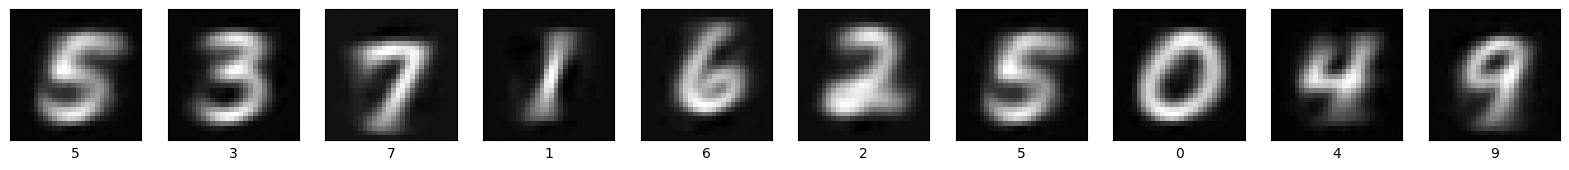

In [12]:
train(
    seed=SEED,
    input_dim=INPUT_DIM,
    width=WIDTH,
    depth=DEPTH,
    output_dim=OUTPUT_DIM,
    act_fn=ACT_FN,
    batch_size=BATCH_SIZE,
    activity_lr=ACTIVITY_LR,
    param_lr=PARAM_LR,
    test_every=TEST_EVERY,
    n_train_iters=N_TRAIN_ITERS
)